In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os, sys, glob

In [20]:

N = 5
# Константа демпфирования
B = 5
# Жесткость пружин
C = 100
# Жесткость основания
Cs = 1000
# Размер цепочки в м
d = 1.25
# Массы в кг
m = 0.1
# Время моделирования
t = 20.0
# Ускорение свободного падения
g = 9.81
# Высота падения
x0 = 3
# Шаг интегрирования по времени
dt = 1E-3
# Количество шагов по времени
nstep = int(t/dt)
# Массив времени
time = np.linspace(0,t,nstep)
# Массив положений масс
# ----------------- 0. 预分配并给初值 -----------------
x   = np.zeros((N, nstep+1), float)      # Euler  位置
vx  = np.zeros((N, nstep+1), float)      # Euler  速度
x_v = np.zeros((N, nstep+1), float)      # Verlet 位置
vx_v= np.zeros((N, nstep+1), float)      # Verlet 速度 (用中央差分算)

x[:,0]   = d*np.arange(N)/N + x0         # 初始直链
x_v[:,0] = x[:,0].copy()                 # 两方法同起点

l = d/N                                  # 每段自然长度

# -------- 1⃣ 先做 Verlet 的第一次半步: r(t+Δt) ----------
dx0  = np.diff(x_v[:,0]) - l
F0   = -C*np.append(0.0, dx0) + C*np.append(dx0, 0.0) - m*g
F0[0]-= Cs * x_v[0,0]*(x_v[0,0] < 0)     # 只在伸长时作用
a0_v  = F0/m
x_v[:,1] = x_v[:,0] + 0.5*a0_v*dt**2     # v₀=0，所以只有 ½aΔt²

# 可选：若你有非零初速度，把 vx_v[:,0] 赋上然后
#       x_v[:,1] = x_v[:,0] + vx_v[:,0]*dt + 0.5*a0_v*dt**2

# -------- 2⃣ 主循环：i 表示 “现在已知到 t = i·Δt” ----------
import time as pytime
tic = pytime.time()

for i in range(nstep):
    # ===== 欧拉 =======================================
    dx  = np.diff(x[:,i]) - l
    F   = -C*np.append(0.0, dx) + C*np.append(dx, 0.0) - m*g
    F[0]-= Cs * x[0,i]*(x[0,i] < 0)
    a    = F/m
    vx[:, i+1] = vx[:, i] + a*dt
    x [:, i+1] = x [:, i] + vx[:, i+1]*dt

    # ===== 位置‑Verlet (从 i>=1 开始才有 r_{i-1}) =====
    if i >= 1:
        dx_v  = np.diff(x_v[:, i]) - l
        F_v   = -C*np.append(0.0, dx_v) + C*np.append(dx_v, 0.0) - m*g
        F_v[0]-= Cs * x_v[0,i]*(x_v[0,i] < 0)
        a_v   = F_v / m
        x_v[:, i+1] = 2*x_v[:, i] - x_v[:, i-1] + a_v*dt**2          # r(t+Δt)

        # 用中央差分求 v(t)  → 公式中的第二行
        vx_v[:, i]   = (x_v[:, i+1] - x_v[:, i-1]) / (2*dt)

# 循环完后再补最后一格速度 v(t_final)
vx_v[:, -1] = (x_v[:, -1] - x_v[:, -2]) / dt

print(f"双方法计算完成，用时 {pytime.time()-tic:.1f} 秒")

双方法计算完成，用时 0.4 秒


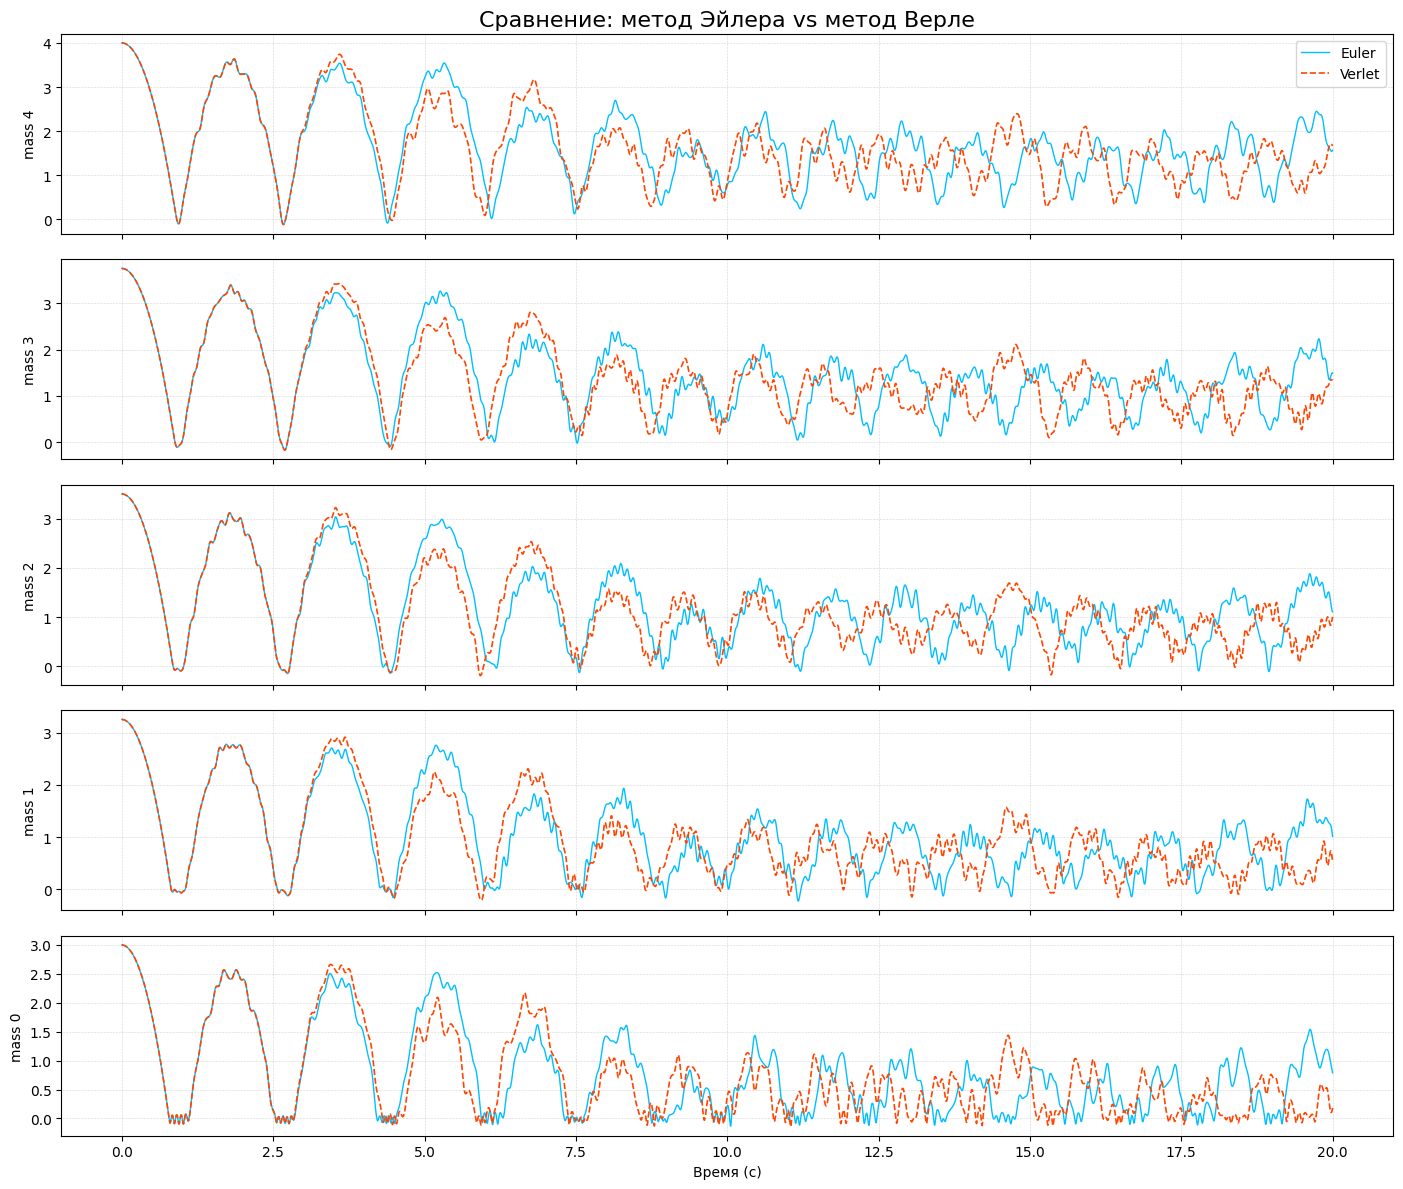

In [21]:
colors = ['deepskyblue', 'orangered']
styles = ['-', '--']
labels = ['Euler', 'Verlet']
fig, axes = plt.subplots(5, 1, figsize=(14, 12), sharex=True)

for i, ax in enumerate(axes):
    idx = 4 - i
    ax.plot(time, x[idx][1:],     label=labels[0], color=colors[0], lw=1.0, linestyle=styles[0])
    ax.plot(time, x_v[idx][1:],   label=labels[1], color=colors[1], lw=1.2, linestyle=styles[1])
    ax.set_ylabel(f'mass {idx}')
    ax.grid(True, which='both', ls=':', lw=0.4)
    if i == 0:
        ax.set_title('Сравнение: метод Эйлера vs метод Верле', fontsize=16)
    if i == 4:
        ax.set_xlabel('Время (с)')
    if i == 0:
        ax.legend(loc='upper right')

plt.tight_layout(h_pad=1.5)
plt.show()